In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers datasets accelerate scikit-learn sentencepiece

In [ ]:
#importing the necessary libraries
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt




In [ ]:
cd /content/drive/MyDrive/mbti-bert-master

/content/drive/MyDrive/mbti-bert-master


In [ ]:
#importing the dataset into a DataFrame
df = pd.read_csv('mbti_1.csv')

In [ ]:
#removing URLs and punctuation from dataset
# 1. Replace '|||' with a space (mimics the split/join logic)
df['posts'] = df['posts'].str.replace(r'\|\|\|', ' ', regex=True)

# 2. Remove URLs
df['posts'] = df['posts'].str.replace(r"http\S+", "", regex=True)

# 3. Remove punctuation and numbers
df['posts'] = df['posts'].str.replace(r"[-/@.?!_,:;()|0-9]", "", regex=True)

# 4. Remove extra whitespace (mimics the split('  ') logic but more robust)
df['posts'] = df['posts'].str.replace(r"\s+", " ", regex=True).str.strip()

df.head(10)



,type,posts
0,INFJ,' enfp and intj moments sportscenter not top t...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one Of course to which I say I know that...
3,INTJ,'Dear INTP I enjoyed our conversation the othe...
4,ENTJ,'You're fired That's another silly misconcepti...
5,INTJ,' Science is not perfect No scientist claims t...
6,INFJ,'No I can't draw on my own nails haha Those we...
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,I'm not sure that's a good question The distin...
9,INTP,' I'm in this position where I have to actuall...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bắt đầu huấn luyện...
Epoch 1/4: Train Loss: 2.6968 | Val Loss: 2.3723
--> Đã lưu lại bộ tham số tốt nhất tại Epoch 1
Epoch 2/4: Train Loss: 2.1100 | Val Loss: 1.8308
--> Đã lưu lại bộ tham số tốt nhất tại Epoch 2
Epoch 3/4: Train Loss: 1.7386 | Val Loss: 1.6486
--> Đã lưu lại bộ tham số tốt nhất tại Epoch 3
Epoch 4/4: Train Loss: 1.4365 | Val Loss: 1.6518

Classification Report (Dựa trên Best Model):
              precision    recall  f1-score   support

        ENFJ       0.47      0.55      0.51        38
        ENFP       0.61      0.53      0.57       135
        ENTJ       0.26      0.72      0.38        46
        ENTP       0.62      0.42      0.50       137
        ESFJ       0.13      0.33      0.19         9
        ESFP       0.14      0.40      0.21        10
        ESTJ       0.25      0.50      0.33         8
        ESTP       0.30      0.72      0.43        18
        INFJ       0.71      0.57      0.63       294
        INFP       0.75      0.56      0.64       366


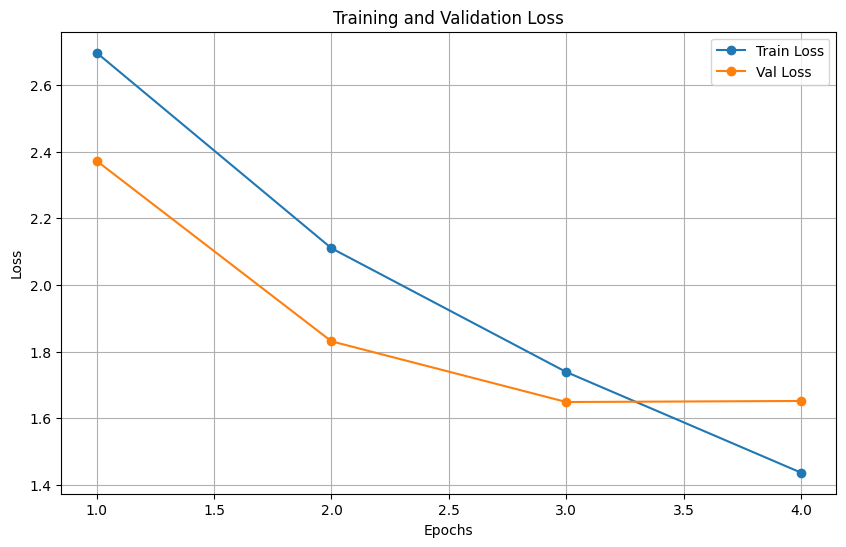

In [ ]:
import pandas as pd
import numpy as np
import torch
import copy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW # Corrected import for AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# ==========================================
# 1. Cấu hình thông số
# ==========================================
MAX_LEN = 512
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unique_types = sorted(df['type'].unique())
label_map = {t: i for i, t in enumerate(unique_types)}
df['label'] = df['type'].map(label_map)

# Tính toán Class Weights để xử lý mất cân bằng dữ liệu
classes = np.unique(df['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])
class_weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)

# Chia tập dữ liệu
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# ==========================================
# 3. Dataset & DataLoader
# ==========================================
class MBTIDataset(Dataset):
    def __init__(self, posts, labels, tokenizer, max_len):
        self.posts = posts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.posts)

    def __getitem__(self, item):
        encoding = self.tokenizer.encode_plus(
            str(self.posts[item]),
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[item], dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_ds = MBTIDataset(df_train.posts.to_numpy(), df_train.label.to_numpy(), tokenizer, MAX_LEN)
val_ds = MBTIDataset(df_val.posts.to_numpy(), df_val.label.to_numpy(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

# ==========================================
# 4. Khởi tạo Model & Optimizer
# ==========================================
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=16)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# ==========================================
# 5. Vòng lặp Huấn luyện (Có lưu Best Model)
# ==========================================
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
history = {'train_loss': [], 'val_loss': []}

print("Bắt đầu huấn luyện...")

for epoch in range(EPOCHS):
    # --- PHASE: TRAINING ---
    model.train()
    train_losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # --- PHASE: VALIDATION ---
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            outputs = model(input_ids, attention_mask=attention_mask)
            v_loss = loss_fn(outputs.logits, labels)
            val_losses.append(v_loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Kiểm tra và lưu trọng số tốt nhất
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"--> Đã lưu lại bộ tham số tốt nhất tại Epoch {epoch+1}")

# ==========================================
# 6. Đánh giá cuối cùng & Vẽ biểu đồ
# ==========================================

# Tải lại bộ trọng số tốt nhất
model.load_state_dict(best_model_wts)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# In Classification Report
print("\nClassification Report (Dựa trên Best Model):")
print(classification_report(all_labels, all_preds, target_names=unique_types))

# Vẽ biểu đồ Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), history['train_loss'], label='Train Loss', marker='o')
plt.plot(range(1, EPOCHS + 1), history['val_loss'], label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()